In [120]:
# Module for data manipulation
import pandas as pd
# Module for linear algebra calculation
import numpy as np
# Module for constructing the data
from sklearn.datasets import make_regression
# Module for factor analysis
from factor_analyzer import FactorAnalyzer
# Module for adequacy test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
# Module for standardization
from sklearn.preprocessing import MinMaxScaler
# Module for data viz
from plotnine import *
import plotnine
# Module for spatial data manipulation
import geopandas as gpd
# Module for spatial data viz
import folium
import branca
import branca.colormap as cm
from folium.features import GeoJson, GeoJsonTooltip
# Module for json file
import json

In [154]:
# Functions
def highlightLoadings(x):
    '''
    highlight the values if they are greater than 0.5 in a Series yellow.
    '''
    return ['background-color: skyblue' if abs(v) > 0.5 else '' for v in x]
def highlightCommunalities(x):
    '''
    highlight the values if they are greater than 0.5 in a Series yellow.
    '''
    return ['background-color: skyblue' if v > 0.5 else '' for v in x]
def highlightEigenvalue(x):
    '''
    highlight the values if they are greater than 1 in a Series yellow.
    '''
    return ['background-color: skyblue' if v > 1 else '' for v in x]

In [122]:
# Read the dataframe
df = pd.read_csv('/Users/jessicaflanagan/Documents/cleaned_data.csv')
# Drop NaN
df.dropna(inplace = True, axis = 1)
# Dimension of data
print('Dimension of data: {} rows and {} columns'.format(len(df), len(df.columns)))
df.head()

Dimension of data: 38 rows and 13 columns


,county,snap_pc,poverty_pop_pc,precipitation,lib_card_pc,lib_ct_pc,aqi,broad_un_sq_mi,elec_rate,uvi,avail_yard_sq_mi,benz_dose_pc,farm_market_pc
0,Allen,0.110729,0.117,38.33,0.325718,0.000069,263,258,0.135935,3892,0.000289,11.8,0.000010
1,Ashtabula,0.181757,0.178,41.82,0.579927,0.000093,178,453,0.176708,3704,0.000301,11.6,0.000021
2,Belmont,0.134050,0.182,49.60,0.389962,0.000137,240,376,0.126281,3770,0.000302,13.0,0.000015
3,Butler,0.110010,0.117,44.81,1.029558,0.000021,273,79,0.145779,3981,0.000289,18.6,0.000013
4,Clark,0.192547,0.152,47.03,0.653818,0.000045,241,157,0.154299,3902,0.000299,17.0,0.000007


In [123]:
# Filter the numerical data
df_fix = df[[col for col in list(df.columns) if col not in ['county']]]
# Standardize the factors
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(data = scaler.fit_transform(df_fix),
                         columns = df_fix.columns)
df_scaled.head()

,snap_pc,poverty_pop_pc,precipitation,lib_card_pc,lib_ct_pc,aqi,broad_un_sq_mi,elec_rate,uvi,avail_yard_sq_mi,benz_dose_pc,farm_market_pc
0,0.339262,0.396648,0.405277,0.090896,0.441704,0.959854,0.514412,0.270903,0.658784,0.532816,0.157025,0.206562
1,0.657096,0.737430,0.589446,0.419240,0.635137,0.649635,0.946785,0.551273,0.023649,0.765702,0.148760,0.430587
2,0.443618,0.759777,1.000000,0.173875,1.000000,0.875912,0.776053,0.204519,0.246622,0.781934,0.206612,0.318348
3,0.336044,0.396648,0.747230,1.000000,0.042121,0.996350,0.117517,0.338590,0.959459,0.536344,0.438017,0.268865
4,0.705378,0.592179,0.864380,0.514682,0.238527,0.879562,0.290466,0.397178,0.692568,0.723359,0.371901,0.154909


In [124]:
# Adequacy test - Bartlett's test
chiSquareValue, pValue = calculate_bartlett_sphericity(df_scaled)
print('Chi-square value : {}'.format(round(chiSquareValue, ndigits = 3)))
print('p-value          : {}'.format(round(pValue, ndigits = 3)))

Chi-square value : 173.837
p-value          : 0.0


In [125]:
# Adequacy test - Kaiser-Meyer-Olkin test
KMO, KMO_model = calculate_kmo(df_scaled)
print('KMO value : {}'.format(round(KMO_model, ndigits = 3)))

KMO value : 0.569


/Users/jessicaflanagan/.pyenv/versions/3.10.7/lib/python3.10/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.


In [155]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors = 2, rotation = None)
fa.fit(df_scaled)
# The communalities
df_communalities = pd.DataFrame(data = {'Column': df_scaled.columns, 'Communality': fa.get_communalities()})
df_communalities.style.apply(highlightCommunalities, subset = ['Communality'])

,Column,Communality
0,snap_pc,0.996894
1,poverty_pop_pc,0.723558
2,precipitation,0.019532
3,lib_card_pc,0.295066
4,lib_ct_pc,0.389548
5,aqi,0.313295
6,broad_un_sq_mi,0.923296
7,elec_rate,0.044487
8,uvi,0.019518
9,avail_yard_sq_mi,0.244983


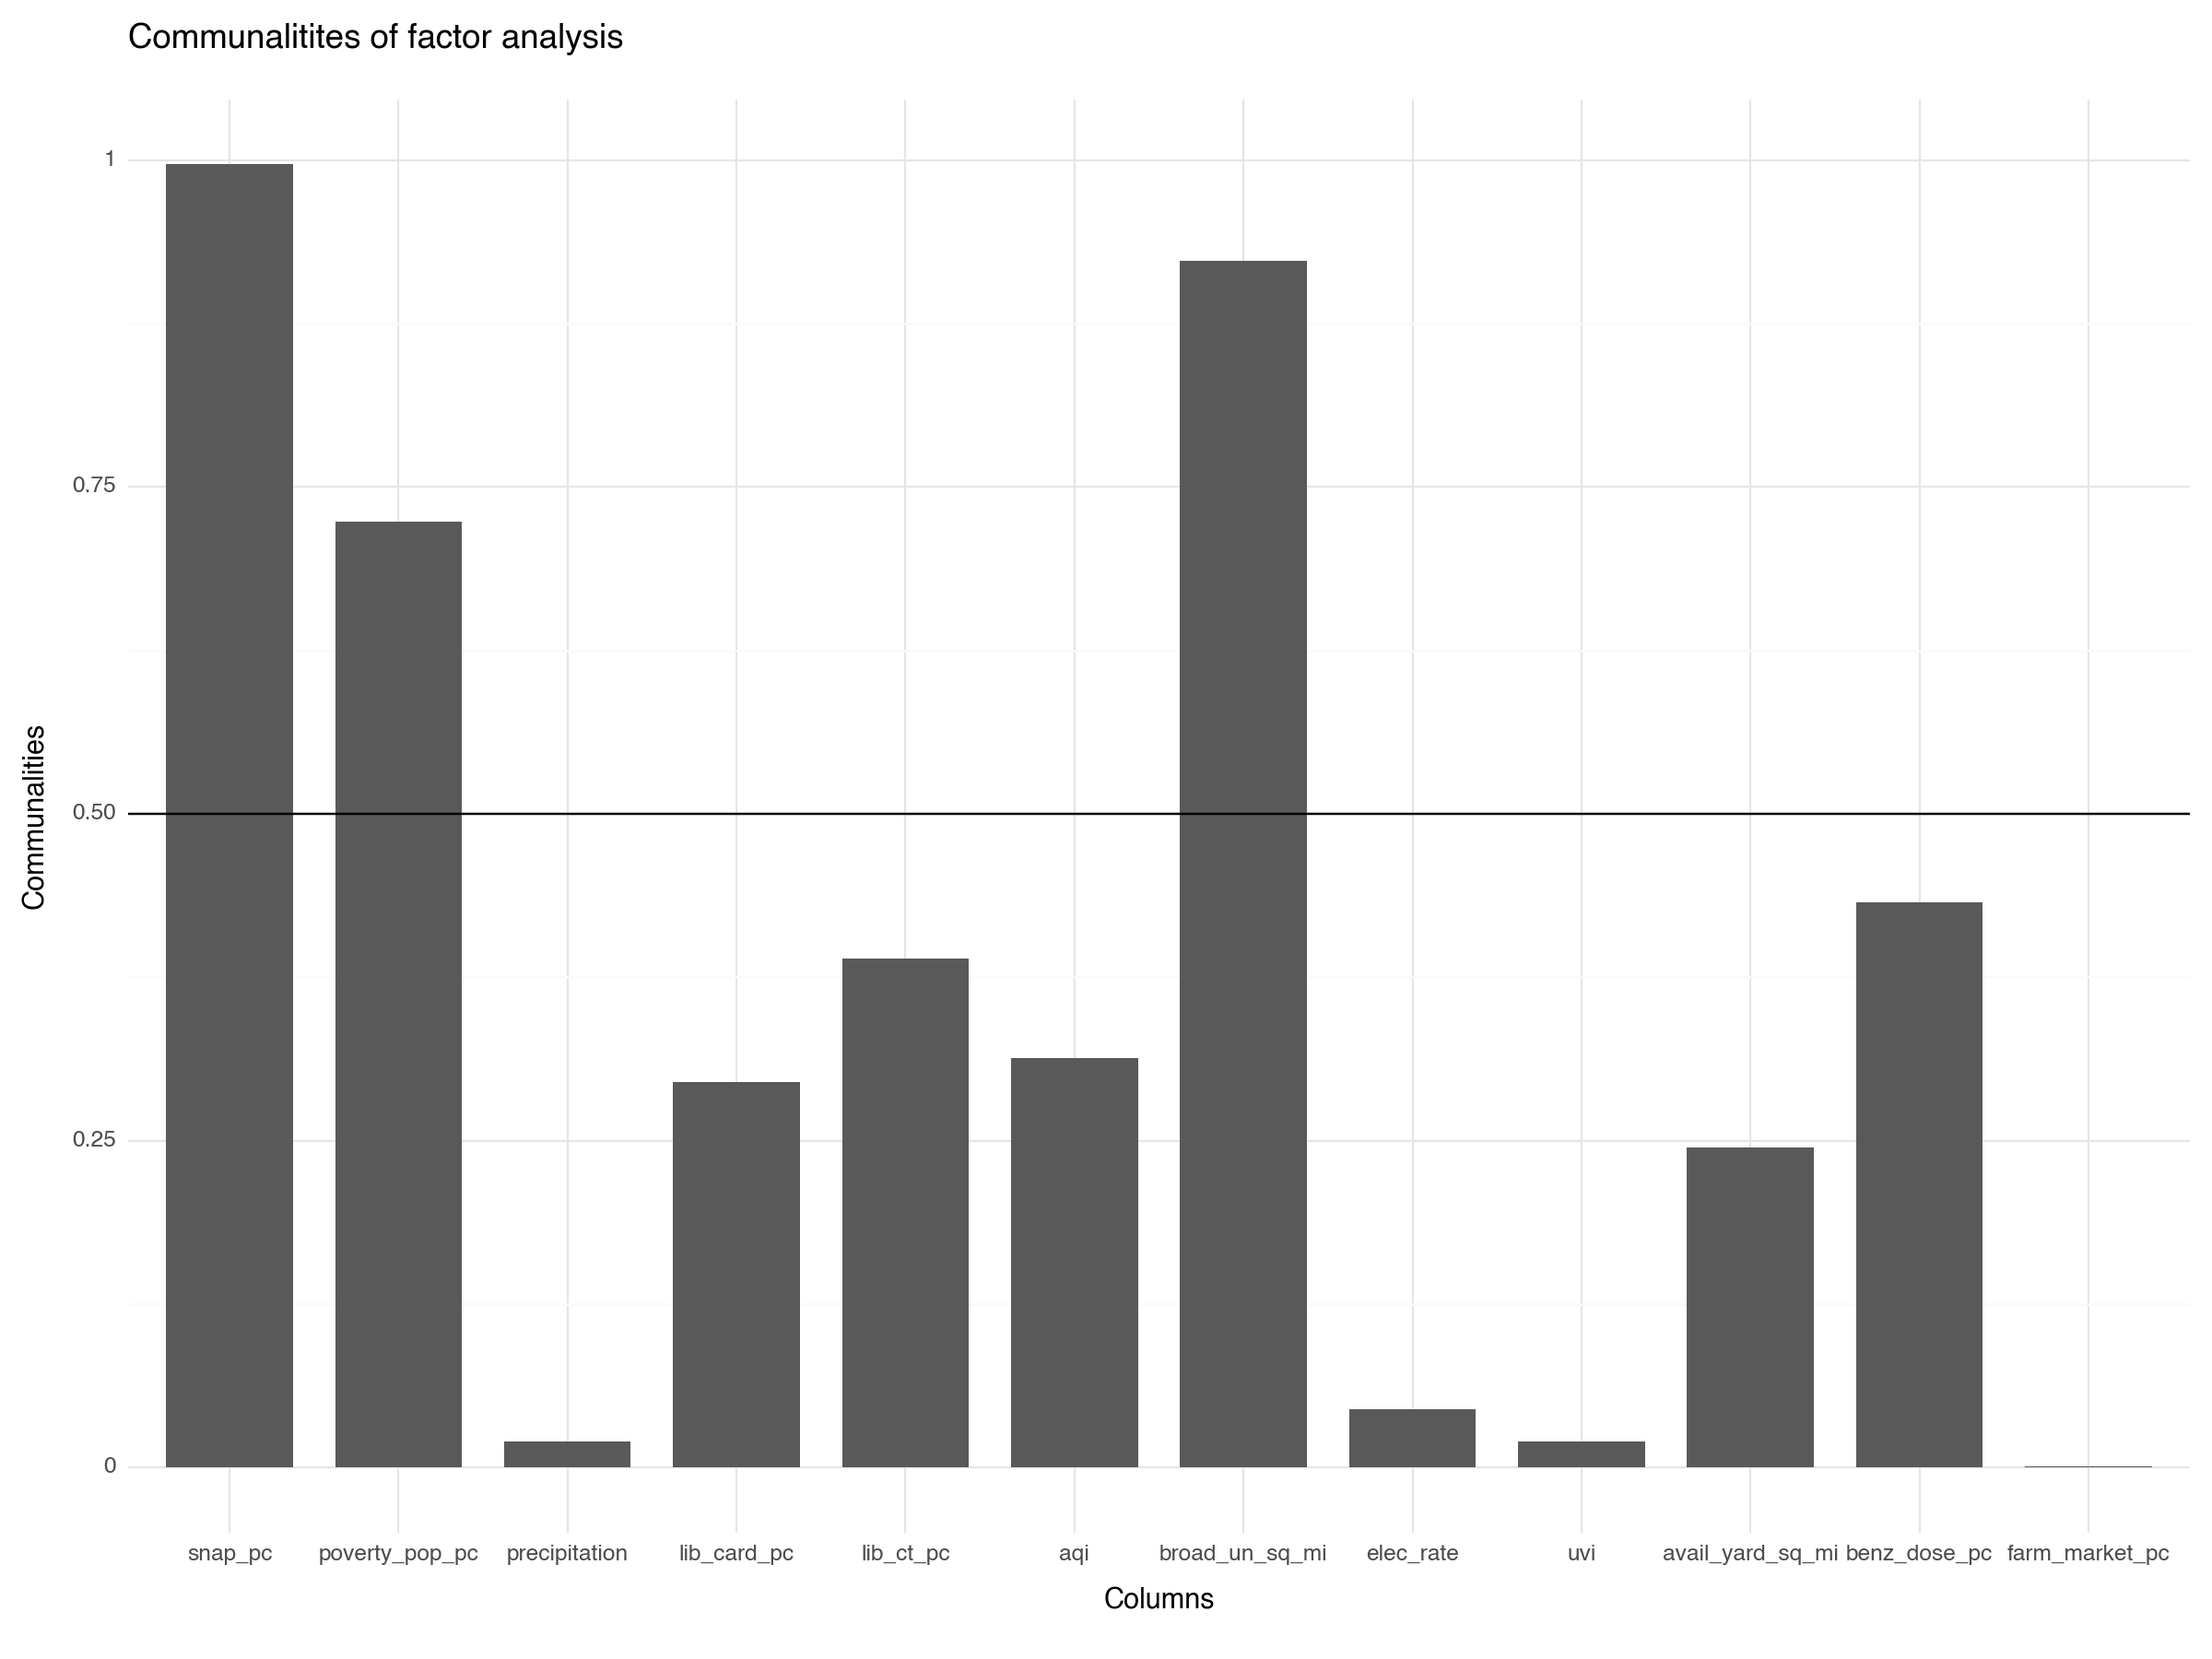

<Figure Size: (1200 x 900)>

In [127]:
# Data viz
plotnine.options.figure_size = (12, 9)
communality_bar = (
    ggplot(data = df_communalities)+
    geom_bar(aes(x = 'Column',
                 y = 'Communality'),
             width = 0.75,
             stat = 'identity')+
    geom_hline(yintercept = 0.5)+
    scale_x_discrete(limits = df_communalities['Column'].tolist())+
    labs(title = 'Communalitites of factor analysis')+
    xlab('Columns')+
    ylab('Communalities')+
    theme_minimal()
)
# Display the viz
communality_bar


In [128]:
# Check Eigenvalues
eigenValue, value = fa.get_eigenvalues()
# Convert the results into a dataframe
df_eigen = pd.DataFrame({'Factor': range(1, len(eigenValue) + 1), 'Eigen value': eigenValue})
df_eigen.style.apply(highlightEigenvalue, subset = ['Eigen value'])

,Factor,Eigen value
0,1,3.155488
1,2,2.006698
2,3,1.647149
3,4,1.450259
4,5,1.093888
5,6,0.777048
6,7,0.552158
7,8,0.417856
8,9,0.401954
9,10,0.239709


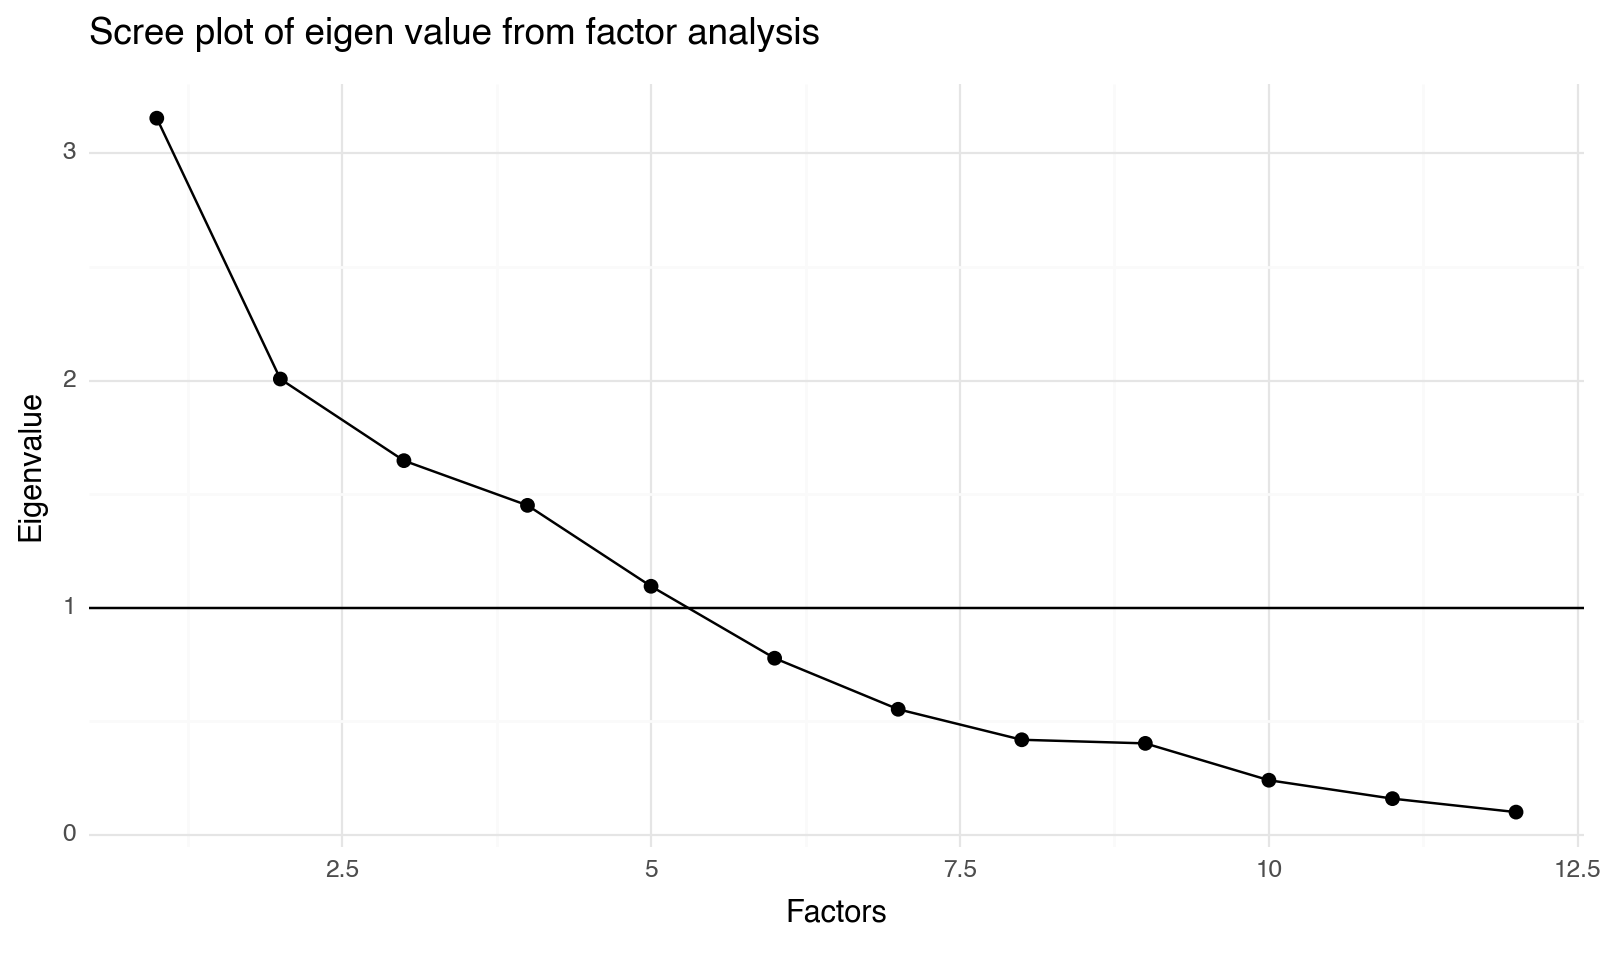

<Figure Size: (800 x 480)>

In [129]:
# Data viz
plotnine.options.figure_size = (8, 4.8)
scree_eigenvalue = (
    ggplot(data = df_eigen)+
    geom_hline(yintercept = 1)+
    geom_line(aes(x = 'Factor',
                  y = 'Eigen value'))+
    geom_point(aes(x = 'Factor',
                   y = 'Eigen value'),
               size = 2)+
    labs(title = 'Plot of eigen values from factor analysis')+
    xlab('Factors')+
    ylab('Eigenvalue')+
    theme_minimal()
)
# Display the viz
scree_eigenvalue

In [132]:
# Factor analysis without rotation
fa = FactorAnalyzer(n_factors = 2, rotation = None)
fa.fit(df_scaled)
# Create a factor's names
facs = ['Factors' + ' ' + str(i + 1) for i in range(2)]
print(facs)

# Loading factors
pd.DataFrame(data = fa.loadings_, index = df_scaled.columns, columns = facs).style.apply(highlightLoadings)

['Factors 1', 'Factors 2']


,Factors 1,Factors 2
snap_pc,0.892525,0.447542
poverty_pop_pc,0.656497,0.540897
precipitation,0.083856,-0.111806
lib_card_pc,-0.216967,0.497987
lib_ct_pc,0.557540,-0.280530
aqi,-0.298720,0.473352
broad_un_sq_mi,0.664664,-0.693916
elec_rate,-0.109541,-0.180244
uvi,-0.120439,0.070796
avail_yard_sq_mi,0.476356,0.134418


In [134]:
# Explained variance
idx = ['SS Loadings', 'Proportion Variance', 'Cumulative Variance']
df_variance = pd.DataFrame(data = fa.get_factor_variance(), index = idx, columns = facs)
# Ratio of variance
ratioVariance = fa.get_factor_variance()[1] / fa.get_factor_variance()[1].sum()
df_ratio_var = pd.DataFrame(data = ratioVariance.reshape((1, 2)), index = ['Ratio Variance'], columns = facs)
# New completed dataframe
pd.concat([df_variance,df_ratio_var])

,Factors 1,Factors 2
SS Loadings,2.804945,1.598301
Proportion Variance,0.233745,0.133192
Cumulative Variance,0.233745,0.366937
Ratio Variance,0.637017,0.362983


In [135]:
# Factor analysis with rotation
fa = FactorAnalyzer(n_factors = 2, rotation = 'varimax')
fa.fit(df_scaled)
# Create a factor's names
facs = ['Factors' + ' ' + str(i + 1) for i in range(2)]
print(facs)
# Loading factors
pd.DataFrame(data = fa.loadings_, index = df_scaled.columns, columns = facs).style.apply(highlightLoadings)

['Factors 1', 'Factors 2']


,Factors 1,Factors 2
snap_pc,0.991698,0.115886
poverty_pop_pc,0.845663,-0.091716
precipitation,0.008713,0.139487
lib_card_pc,0.092024,-0.535348
lib_ct_pc,0.312018,0.540549
aqi,0.010168,-0.559635
broad_un_sq_mi,0.174624,0.944882
elec_rate,-0.190507,0.090522
uvi,-0.061804,-0.125292
avail_yard_sq_mi,0.471951,0.149148


In [137]:
# Explained variance
idx = ['SS Loadings', 'Proportion Variance', 'Cumulative Variance']
df_variance = pd.DataFrame(data = fa.get_factor_variance(), index = idx, columns = facs)
# Ratio of variance
ratioVariance = fa.get_factor_variance()[1] / fa.get_factor_variance()[1].sum()
df_ratio_var = pd.DataFrame(data = ratioVariance.reshape((1, 2)), index = ['Ratio Variance'], columns = facs)
# New completed dataframe
pd.concat([df_variance,df_ratio_var])

,Factors 1,Factors 2
SS Loadings,2.441311,1.961935
Proportion Variance,0.203443,0.163495
Cumulative Variance,0.203443,0.366937
Ratio Variance,0.554434,0.445566


In [138]:
# The factor scores
df_factors = pd.DataFrame(data = fa.fit_transform(df_scaled),
                          index = pd.MultiIndex.from_frame(df[['county']]),
                          columns = facs)
print(df_factors)

            Factors 1  Factors 2
county                          
Allen       -0.035102   0.203780
Ashtabula    1.137666   1.357950
Belmont      0.072968   1.078478
Butler      -0.308904  -1.177214
Clark        1.660155  -0.794206
Clermont    -1.038783  -0.837953
Columbiana   0.640470   0.969404
Cuyahoga     1.286087  -1.543659
Delaware    -1.563900  -0.427808
Erie         0.417006  -0.818000
Fairfield   -0.555387   0.405352
Franklin     0.046226  -1.051264
Geauga      -1.657315   0.184772
Greene      -1.040715   0.395501
Hamilton     0.403721  -1.492806
Hancock     -0.864937   1.674252
Lake        -0.940335  -0.950346
Licking     -0.012657   0.976569
Lorain      -0.256172  -0.502708
Lucas        1.173625  -0.911609
Mahoning     1.658179  -0.929538
Marion       0.999306  -0.327553
Medina      -1.098961  -0.554951
Miami       -0.257143   0.026649
Montgomery   0.263787  -0.532580
Muskingum    0.809742   1.925952
Portage     -0.714658  -0.564550
Richland    -0.032209  -0.685056
Ross      

In [140]:
# Perform aggregation
dict_index = {}
for i in range(2):
    key = df_factors_scaled.columns[i]
    value = df_factors_scaled.iloc[:,i].values * df_ratio_var.iloc[:,i].values
    dict_index.update({key:value})
# Create a dataframe
df_index = pd.DataFrame(dict_index,
                        index = pd.MultiIndex.from_frame(df[['county']]))
print(df_index)

            Factors 1  Factors 2
county                          
Allen        0.204248   0.215255
Ashtabula    0.364696   0.333610
Belmont      0.239403   0.310665
Butler       0.216295   0.106204
Clark        0.395257   0.122573
Clermont     0.107510   0.128288
Columbiana   0.320603   0.308935
Cuyahoga     0.333893   0.000000
Delaware     0.042014   0.164004
Erie         0.225777   0.123138
Fairfield    0.181351   0.242325
Franklin     0.240605   0.037333
Geauga       0.000000   0.200039
Greene       0.138972   0.234692
Hamilton     0.245731   0.010052
Hancock      0.141414   0.407856
Lake         0.094084   0.084197
Licking      0.235875   0.294972
Lorain       0.196478   0.126518
Lucas        0.347751   0.069240
Mahoning     0.411188   0.058841
Marion       0.410654   0.160335
Medina       0.100083   0.130174
Miami        0.192015   0.228539
Montgomery   0.257302   0.122847
Muskingum    0.384669   0.445566
Portage      0.160679   0.093227
Richland     0.261193   0.120277
Ross      

In [141]:
# Assign the composite index and ranking
df_index['Composite Index'] = df_index.sum(axis = 1).values
df_index['Rank'] = df_index['Composite Index'].rank(ascending = False)
df_index = df_index.sort_values(by = 'Rank').reset_index()

In [142]:
stat = ['Above' if i > df_index['Composite Index'].mean() else 'Below' for i in df_index['Composite Index']]
df_index['Status'] = stat
print(df_index)

        county  Factors 1  Factors 2  Composite Index  Rank Status
0    Muskingum   0.384669   0.445566         0.830235   1.0  Above
1       Scioto   0.554434   0.256443         0.810877   2.0  Above
2         Ross   0.350465   0.401700         0.752165   3.0  Above
3    Ashtabula   0.364696   0.333610         0.698306   4.0  Above
4   Tuscarawas   0.248362   0.405556         0.653918   5.0  Above
5   Columbiana   0.320603   0.308935         0.629538   6.0  Above
6       Marion   0.410654   0.160335         0.570989   7.0  Above
7         Wood   0.160403   0.397216         0.557619   8.0  Above
8      Belmont   0.239403   0.310665         0.550067   9.0  Above
9      Hancock   0.141414   0.407856         0.549270  10.0  Above
10     Licking   0.235875   0.294972         0.530847  11.0  Above
11       Clark   0.395257   0.122573         0.517830  12.0  Above
12    Mahoning   0.411188   0.058841         0.470029  13.0  Above
13    Trumbull   0.254176   0.206039         0.460216  14.0  A

In [143]:
# Above and below the average
stat = ['Above' if i > df_index['Composite Index'].mean() else 'Below' for i in df_index['Composite Index']]
df_index['Status'] = stat
print(df_index)

        county  Factors 1  Factors 2  Composite Index  Rank Status
0    Muskingum   0.384669   0.445566         0.830235   1.0  Above
1       Scioto   0.554434   0.256443         0.810877   2.0  Above
2         Ross   0.350465   0.401700         0.752165   3.0  Above
3    Ashtabula   0.364696   0.333610         0.698306   4.0  Above
4   Tuscarawas   0.248362   0.405556         0.653918   5.0  Above
5   Columbiana   0.320603   0.308935         0.629538   6.0  Above
6       Marion   0.410654   0.160335         0.570989   7.0  Above
7         Wood   0.160403   0.397216         0.557619   8.0  Above
8      Belmont   0.239403   0.310665         0.550067   9.0  Above
9      Hancock   0.141414   0.407856         0.549270  10.0  Above
10     Licking   0.235875   0.294972         0.530847  11.0  Above
11       Clark   0.395257   0.122573         0.517830  12.0  Above
12    Mahoning   0.411188   0.058841         0.470029  13.0  Above
13    Trumbull   0.254176   0.206039         0.460216  14.0  A

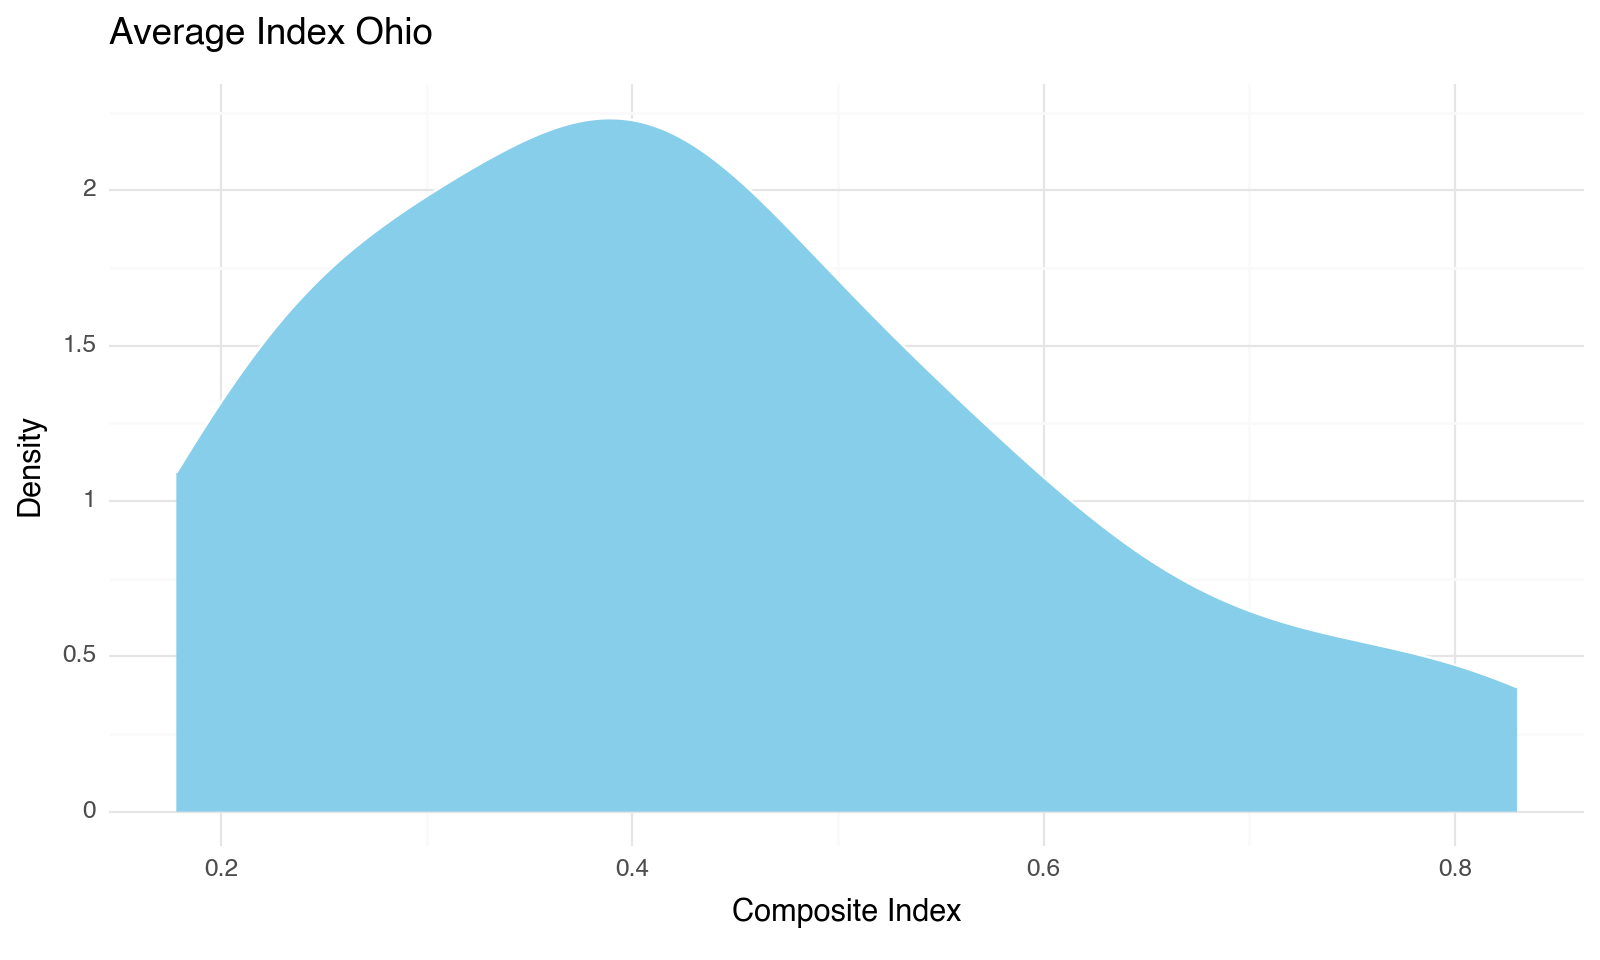

<Figure Size: (800 x 480)>

In [156]:
# Data viz
plotnine.options.figure_size = (8, 4.8)
composite_index_distribution = (
    ggplot(data = df_index)+
    geom_density(aes(x = 'Composite Index'),
                 color = 'white',
                 fill = 'skyblue')+
    labs(title = 'Average Index Ohio')+
    xlab('Composite Index')+
    ylab('Density')+
    theme_minimal()
)
# Display the viz
composite_index_distribution


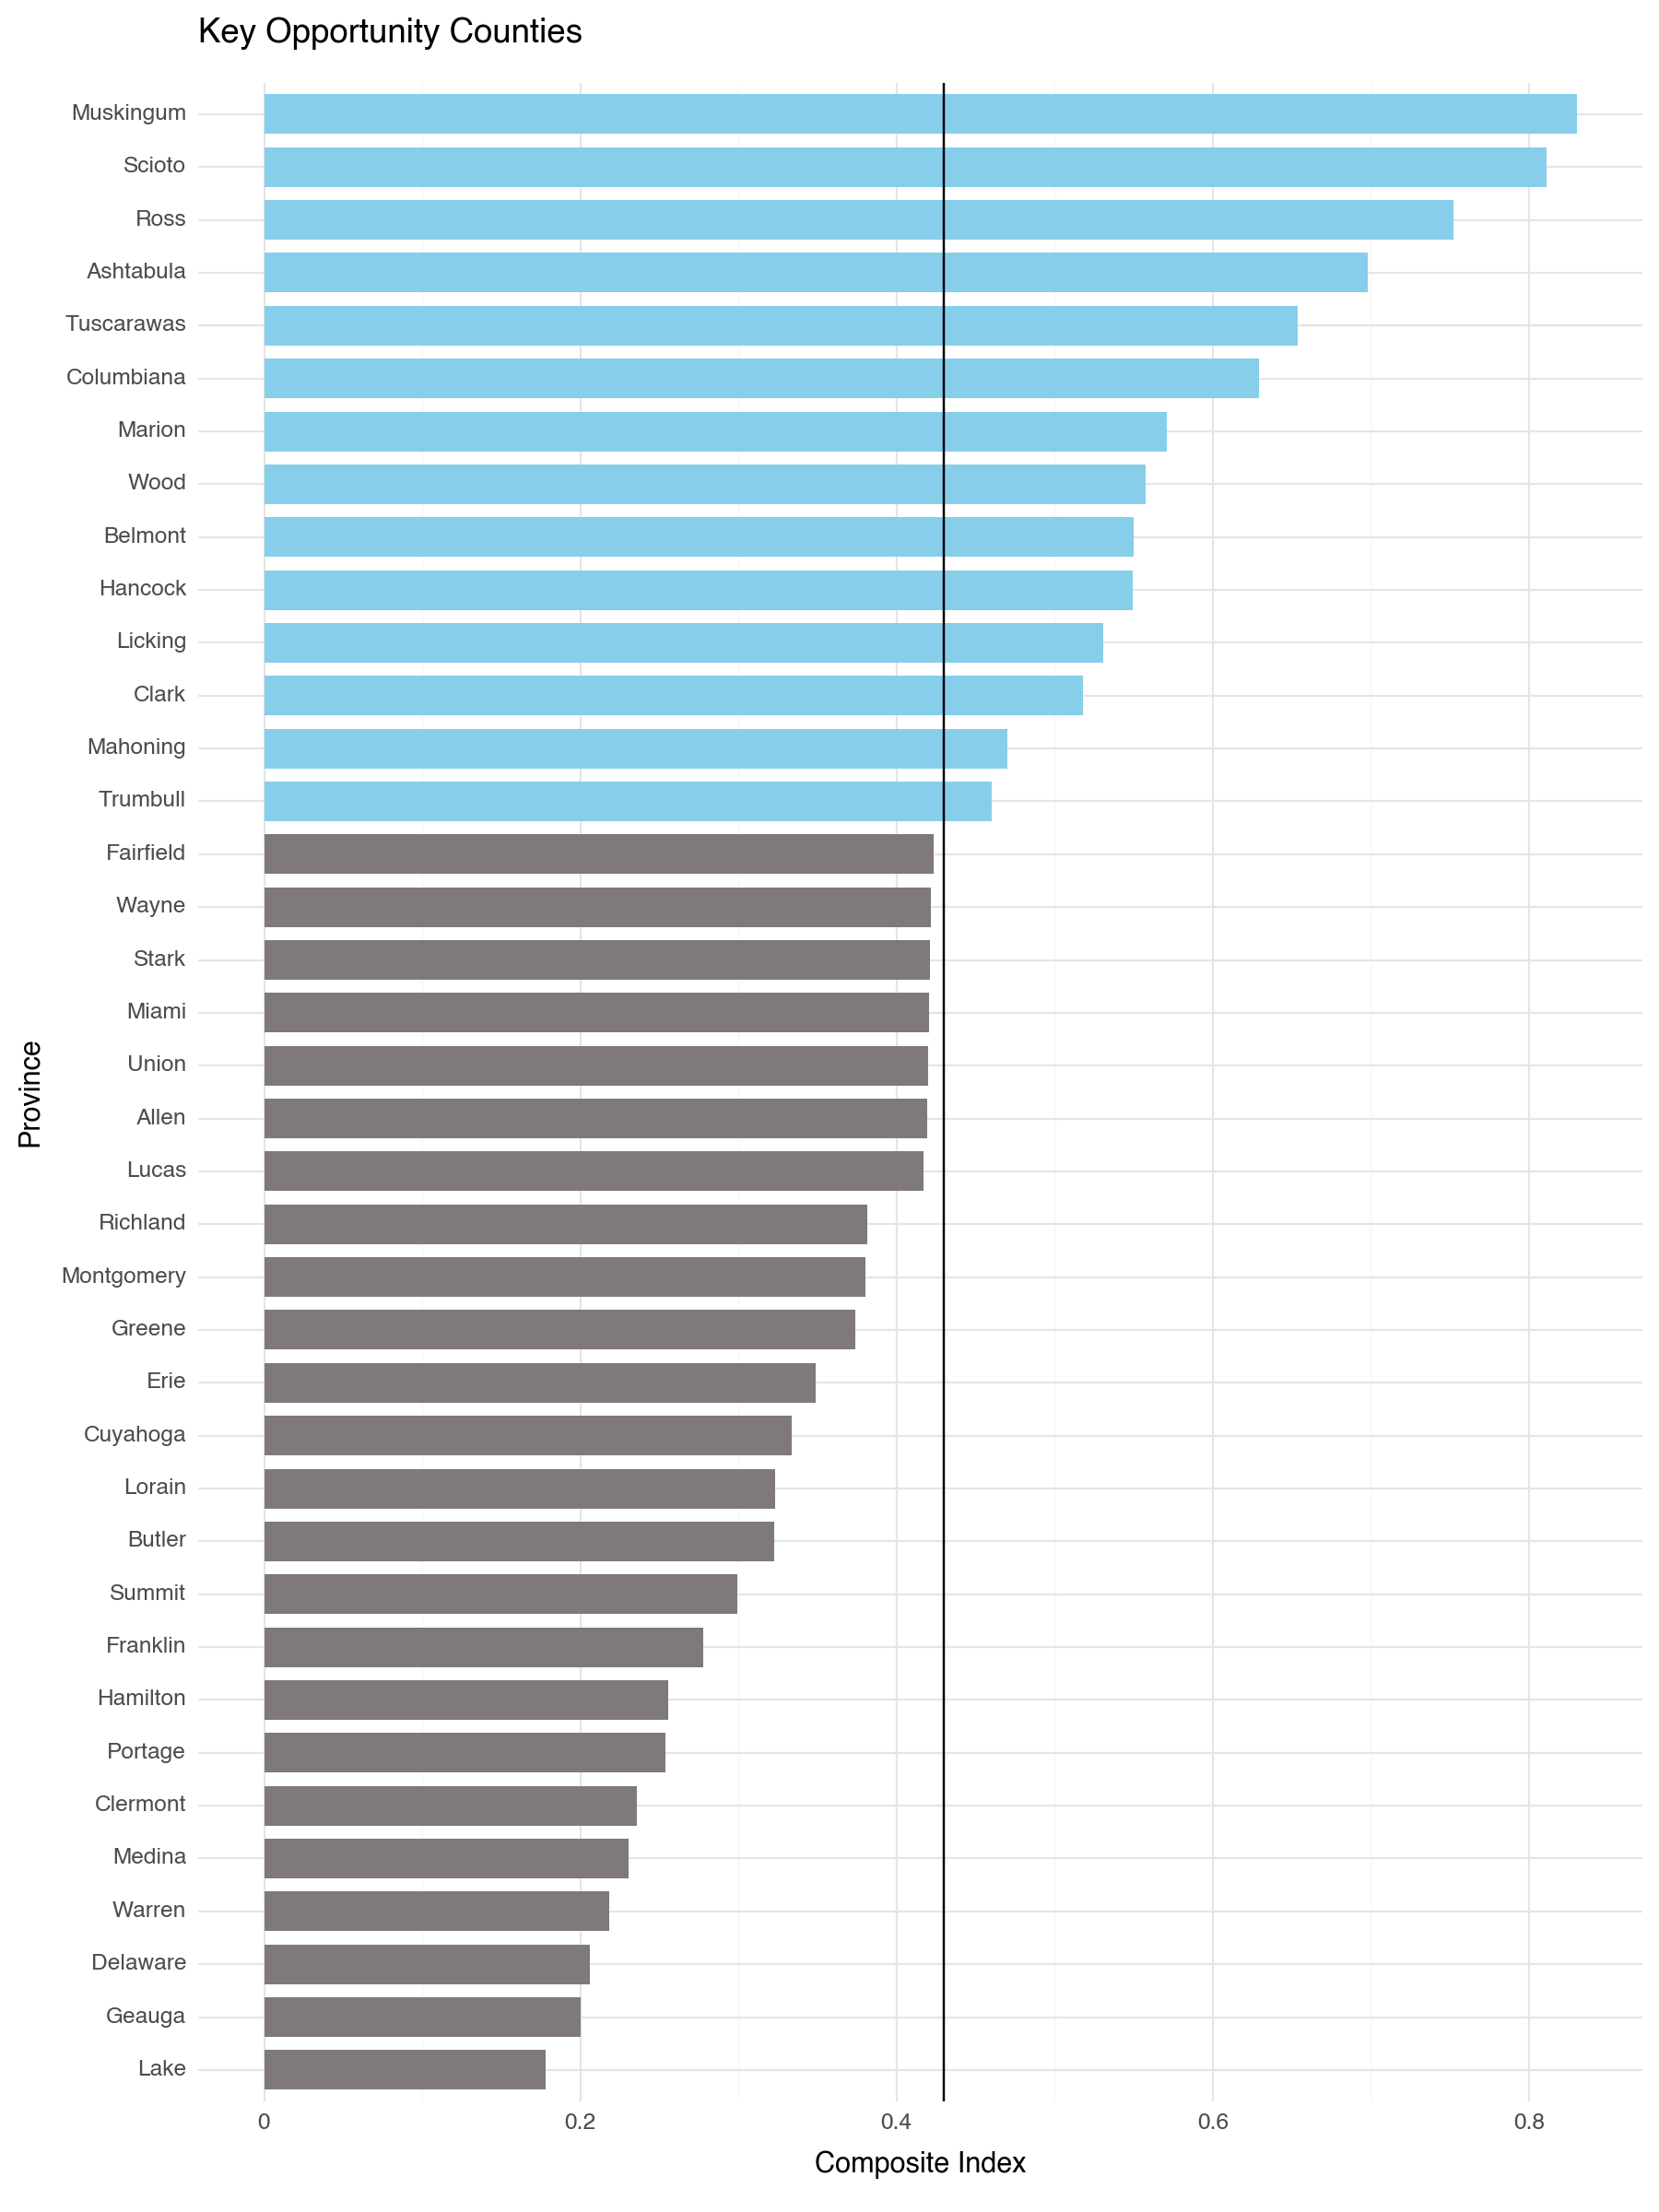

<Figure Size: (900 x 1200)>

In [157]:
# Redefine the data
df_index_reverse = df_index.sort_values(by = 'Rank', ascending = False).reset_index(drop = True)
# Data viz
plotnine.options.figure_size = (9, 12)
composite_index_province = (
    ggplot(data = df_index_reverse)+
    geom_bar(aes(x = 'county',
                 y = 'Composite Index'),
             width = 0.75,
             fill = np.where(df_index_reverse['Status'] == 'Above','skyblue','#80797c'),
             stat = 'identity')+
    geom_hline(yintercept = df_index_reverse['Composite Index'].mean())+
    scale_x_discrete(limits = df_index_reverse['county'].tolist())+
    labs(title = 'Key Opportunity Counties')+
    xlab('Province')+
    ylab('Composite Index')+
    coord_flip()+
    theme_minimal()
)
# Display the viz
composite_index_province

In [146]:
# Redefine the data
df_contribution = pd.melt(frame = df_index_reverse,
                          id_vars = 'county',
                          value_vars = facs,
                          var_name = 'Factor',
                          value_name = 'Factor Value')

print(df_contribution)

        county     Factor  Factor Value
0         Lake  Factors 1      0.094084
1       Geauga  Factors 1      0.000000
2     Delaware  Factors 1      0.042014
3       Warren  Factors 1      0.033549
4       Medina  Factors 1      0.100083
..         ...        ...           ...
71  Tuscarawas  Factors 2      0.405556
72   Ashtabula  Factors 2      0.333610
73        Ross  Factors 2      0.401700
74      Scioto  Factors 2      0.256443
75   Muskingum  Factors 2      0.445566

[76 rows x 3 columns]


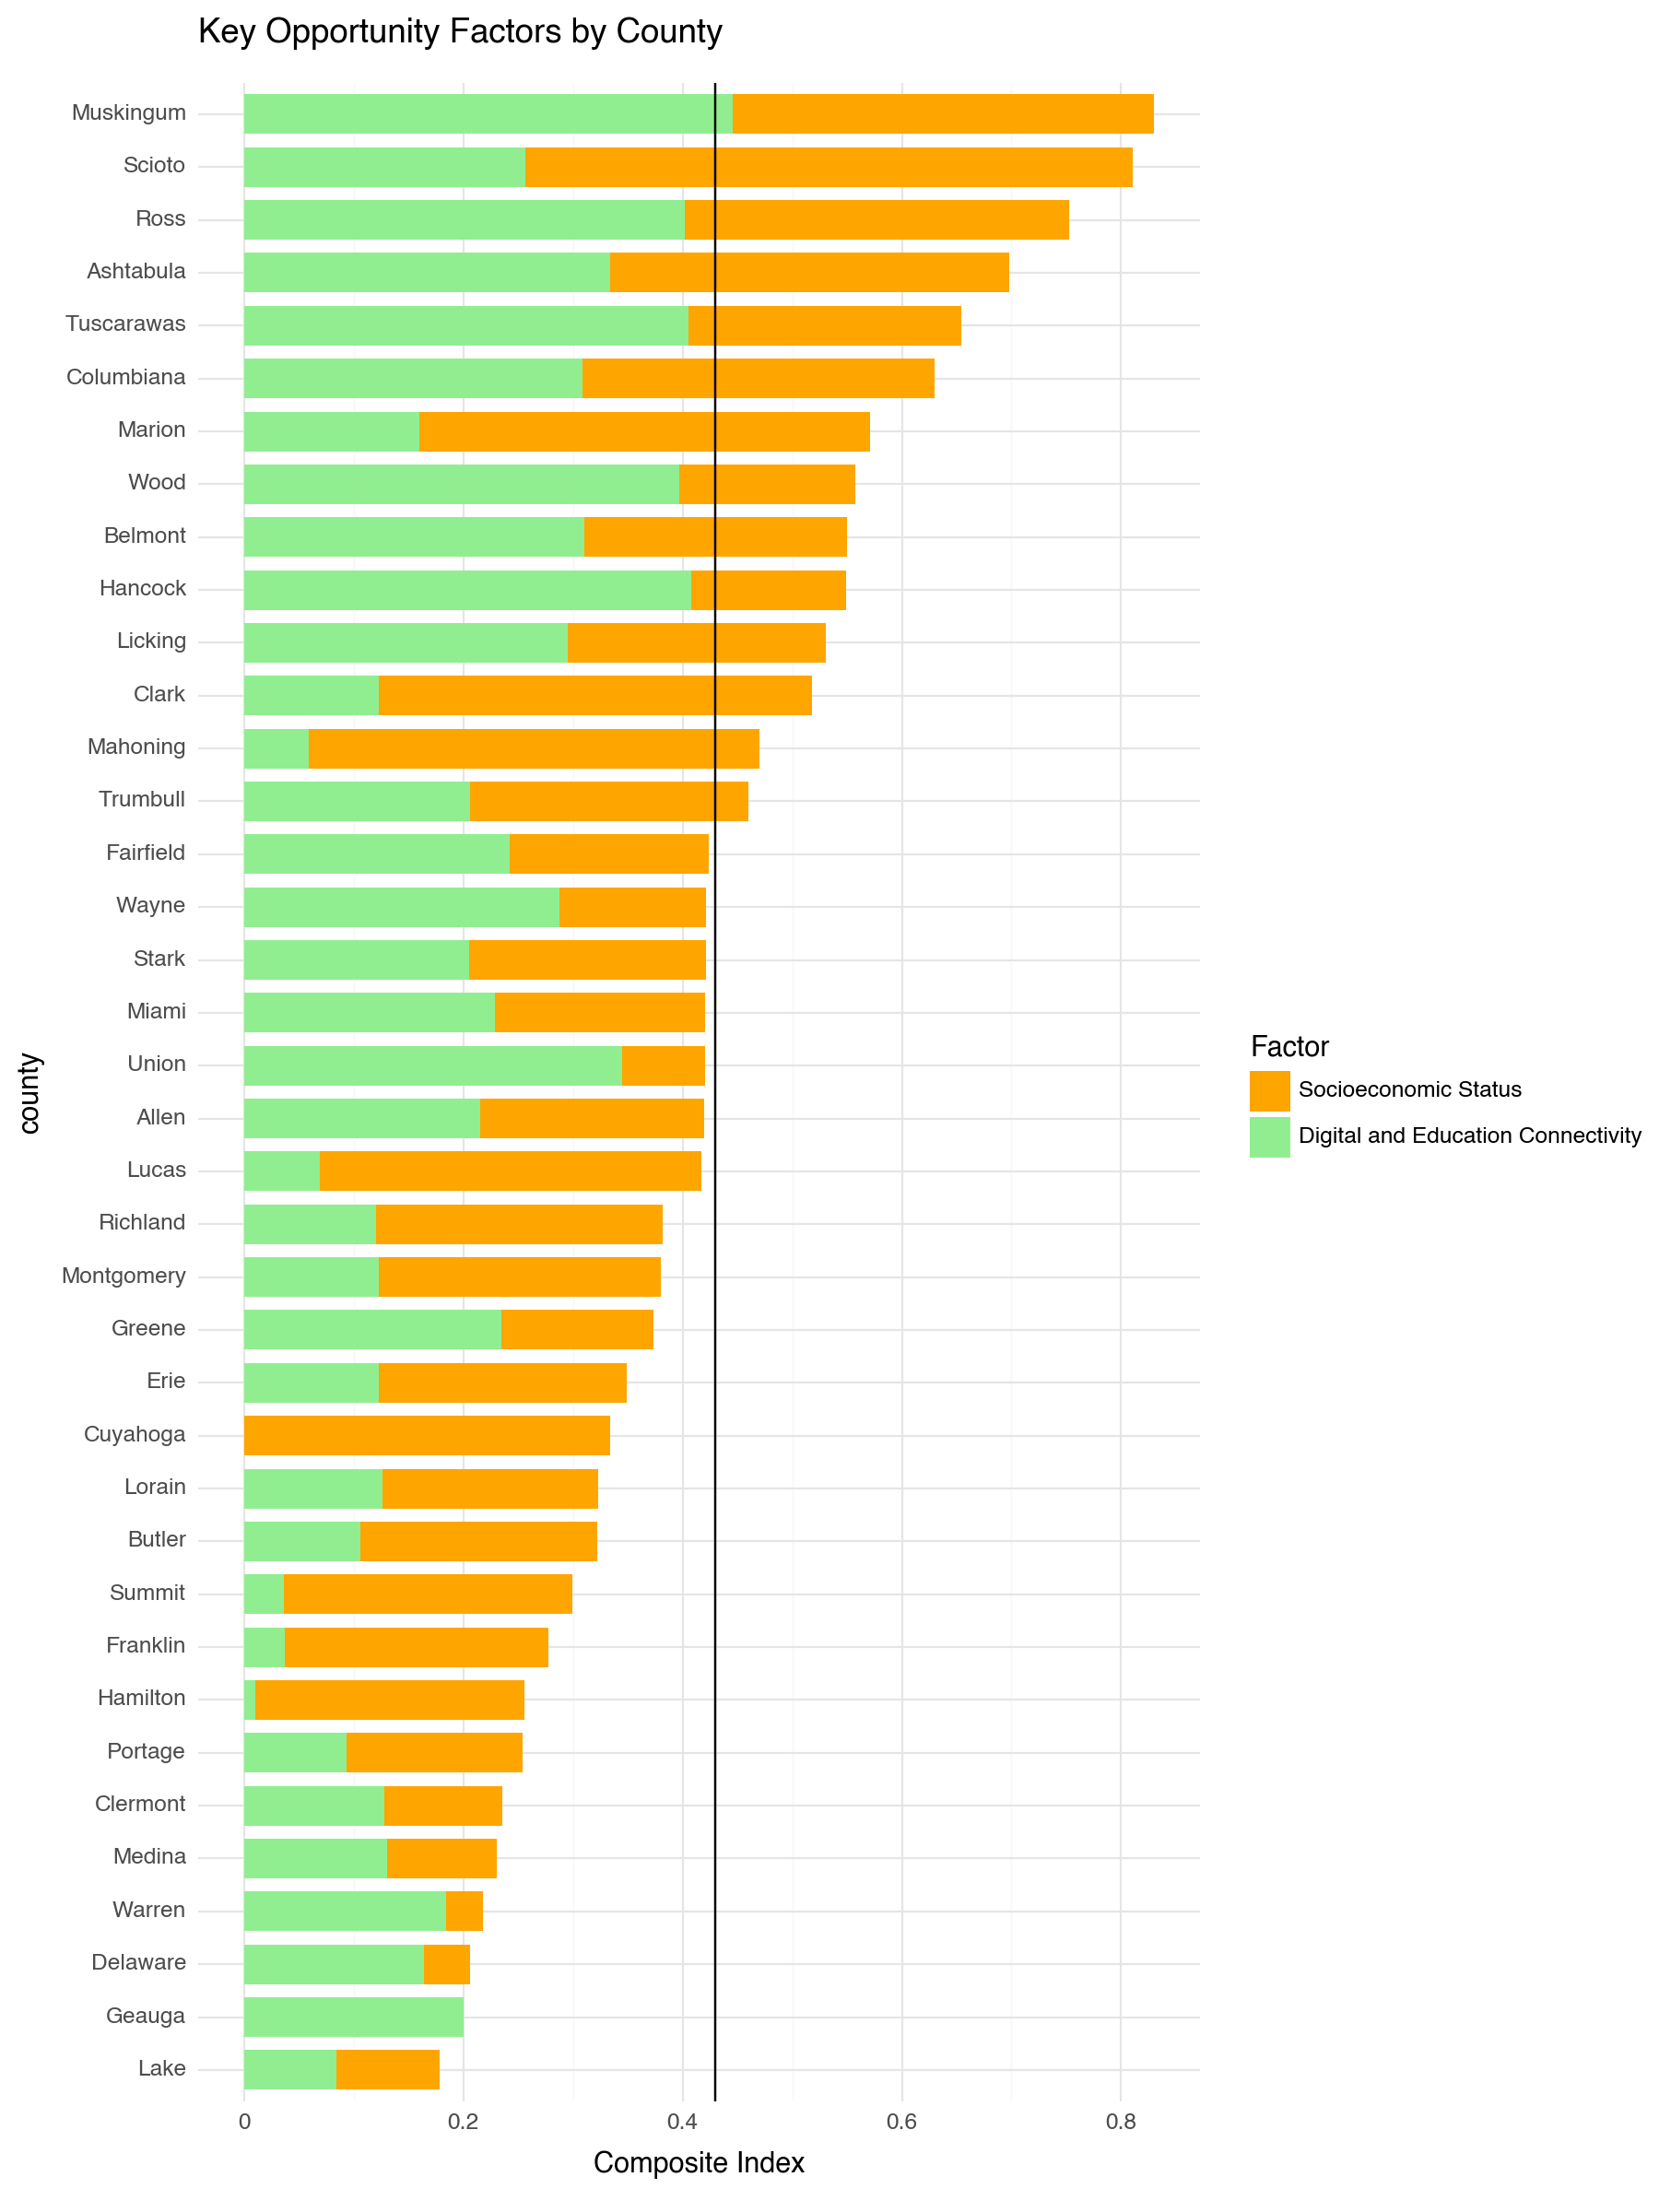

<Figure Size: (900 x 1200)>

In [174]:
# Data viz
plotnine.options.figure_size = (9, 12)
contribution_factors_composite_index = (
     ggplot(data = df_contribution)+
    geom_bar(aes(x = 'county',
                 y = 'Factor Value',
                 fill = 'Factor'),
             width = 0.75,
             position = 'stack',
             stat = 'identity')+
     scale_fill_manual(values = ["orange", "lightgreen"],
                       labels = ["Socioeconomic Status", "Digital and Education Connectivity"])+    
    scale_x_discrete(limits = df_index_reverse['county'].tolist())+
    geom_hline(yintercept = df_index_reverse['Composite Index'].mean())+
    labs(title = 'Key Opportunity Factors by County')+
    xlab('county')+
    ylab('Composite Index')+
    coord_flip()+
    theme_minimal()
)
# Display the viz
contribution_factors_composite_index